## predicting flight trajectory via mulivartiate regression
I want to know if this performs better than my LSTM model (comparing it to the LSTM model that is only trained off of one flight path)?

I may need to perform 2 different regrssions, one where i predict longitude, the other predicting latitude. 

The input data will match that of the LSTM models thus far (one flight without the need to break data into test and train since the output for a linear regression will be a line, that i can then compare the actual obersvaations with the predicted). 

In [57]:
#importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
import sklearn.metrics
import math

## Importing Data (and cleaning it)

In [3]:
#reading and inspecting the data for one flight called 'a198e5'
df = pd.read_csv('Flight_Data/a198e5.csv', index_col = 'time', parse_dates = True)
print(len(df))
df.head(3)


228


,OBJECTID,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitu,geoaltitud,lastposupd,lastcontac
time,,,,,,,,,,,,,,,,
1590364810,1,a198e5,39.353851,-85.572987,245.514862,342.438279,-0.32512,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09
1590364820,2,a198e5,39.375698,-85.581909,249.258603,342.462562,0.00000,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09
1590364830,3,a198e5,39.395966,-85.590124,252.511839,342.450998,0.32512,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09


In [4]:
# REPLACING ALL NAN values in my altitude column for 0 (becasue it is on the ground they no longer report the alt)
#a nessacery step if i hope to predict altiude (LSTM doesn't work with nan)
df['geoaltitud'] = df['geoaltitud'].fillna(0)

#inspect data to make sure it worked
#df.tail(5)

In [6]:
# Looks like x retains all the data used to prdict y... (velocity, heading, vertrate, latposupd, and lastcontact)
indep_vars = ['velocity', 'heading','vertrate','lastposupd','lastcontac']
dep_vars = ['lat', 'lon']
# y are both the lat and lon columns (later try and predict alt as well...)
y = df[dep_vars] 
x = df[indep_vars]

y.head(3)

,lat,lon
time,,
1590364810,39.353851,-85.572987
1590364820,39.375698,-85.581909
1590364830,39.395966,-85.590124


In [7]:
x.head(3)

,velocity,heading,vertrate,lastposupd,lastcontac
time,,,,,
1590364810,245.514862,342.438279,-0.32512,1.590365e+09,1.590365e+09
1590364820,249.258603,342.462562,0.00000,1.590365e+09,1.590365e+09
1590364830,252.511839,342.450998,0.32512,1.590365e+09,1.590365e+09


### Multivariate regresion model
* predicting latitude = mlat
* predicting longitude = mlon

In [9]:
# Fit a multivariate linear regression via OLS model
mlat = spreg.OLS(
    # Dependent variable: the logrithmic price information
    df[['lat']].values, 
    # Independent variables
    df[indep_vars].values,
    # Dependent variable name
    name_y='lat', 
    # Independent variable name
    name_x=indep_vars
)

print(mlat.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :         lat                Number of Observations:         228
Mean dependent var  :     41.0509                Number of Variables   :           6
S.D. dependent var  :      0.7571                Degrees of Freedom    :         222
R-squared           :    -11.4023
Adjusted R-squared  :    -11.6816
Sum squared residual:    1613.633                F-statistic           :     48.2148
Sigma-square        :       7.269                Prob(F-statistic)     :   1.229e-33
S.E. of regression  :       2.696                Log likelihood        :    -546.604
Sigma-square ML     :       7.077                Akaike info criterion :    1105.209
S.E of regression ML:      2.6603                Schwarz criterion     :    1125.785

-----------------------------------------------------------------------------

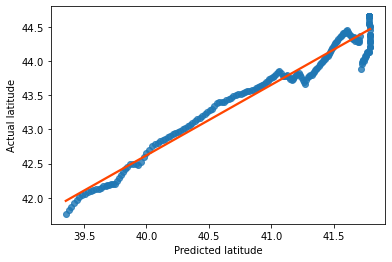

In [10]:
## plotting predicted lat vs actual lat
import seaborn

#flatten vs the original arrays shape
ax = seaborn.regplot(
    df[['lat']].values.flatten(), 
    mlat.predy.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Predicted latitude')
ax.set_ylabel('Actual latitude');


In [11]:
# Fit a multivariate linear regression via OLS model
mlon = spreg.OLS(
    # Dependent variable: the logrithmic price information
    df[['lon']].values, 
    # Independent variables
    df[indep_vars].values,
    # Dependent variable name
    name_y='lon', 
    # Independent variable name
    name_x=indep_vars
)

print(mlon.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :         lon                Number of Observations:         228
Mean dependent var  :    -87.0143                Number of Variables   :           6
S.D. dependent var  :      0.7622                Degrees of Freedom    :         222
R-squared           :  -3710.6946
Adjusted R-squared  :  -3794.2913
Sum squared residual:  489513.067                F-statistic           :     44.4122
Sigma-square        :    2205.014                Prob(F-statistic)     :   1.216e-31
S.E. of regression  :      46.958                Log likelihood        :   -1198.106
Sigma-square ML     :    2146.987                Akaike info criterion :    2408.211
S.E of regression ML:     46.3356                Schwarz criterion     :    2428.787

-----------------------------------------------------------------------------

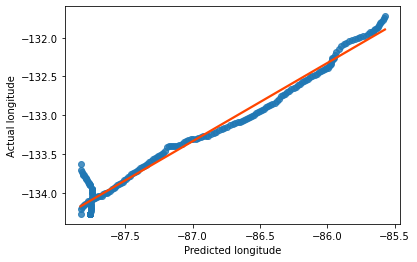

In [12]:
## plotting predicted lat vs actual lat
import seaborn

#flatten vs the original arrays shape
ax = seaborn.regplot(
    df[['lon']].values.flatten(), 
    mlon.predy.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Predicted longitude')
ax.set_ylabel('Actual longitude');

### Plotting the predicted lat/lon against the actual lat lon (in one graph)

The resulting plot, shows that longitude predictions are very wrong, based on the graph, there is almost a 40 degree discrpancy between the predicted and actual longitude. The latitude predictions are also worng (but i think there is less error when compared to the logitude). The actual flight path latitude is between 39 and 41 degrees whereas the predicted latitudevalues are between 41 and 44 degrees. 

41.790802001953125 39.353851318359375
44.657376614728435 41.76258799332478


Text(0.5, 1.0, 'Actual Flight a198e5')

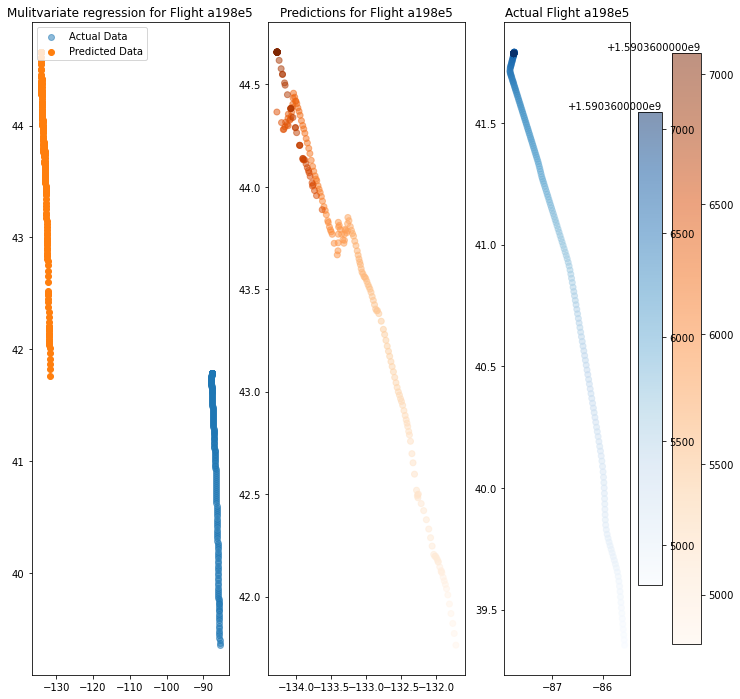

In [54]:
a_lat = df[['lat']].values.flatten()
a_lon = df[['lon']].values.flatten()

print(np.max(a_lat), np.min(a_lat))
print(np.max(mlat.predy.flatten()), np.min(mlat.predy.flatten()))

f, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].scatter(a_lon,a_lat, label='Actual Data', alpha= .5)#actual data
ax[0].legend(loc='upper left')
ax[0].scatter(mlon.predy.flatten(),mlat.predy.flatten(), label='Predicted Data')
ax[0].legend(loc='upper left')
# ax[0].axvline(x=p_lat[199], c='r', linestyle='--')
# ax[0].axhline(y=p_lon[199], c='r', linestyle='--')
ax[0].set_title('Mulitvariate regression for Flight a198e5')

pl1 = ax[1].scatter(mlon.predy.flatten(),mlat.predy.flatten(), label='predicted flight path', alpha= .5,c=df.index, cmap= 'Oranges')
plt.colorbar(pl1)
#ax[1].legend(loc='upper left')
ax[1].set_title('Predictions for Flight a198e5')

pl2 = ax[2].scatter(a_lon,a_lat, label='Actual flight path', alpha= .5, c=df.index, cmap= 'Blues')
plt.colorbar(pl2)
#ax[2].legend(loc='upper left')
ax[2].set_title('Actual Flight a198e5')
#data_predict

### quantifying error for the multivarate regression: 

-normally look at the R2 value, but both these are negative in my current models (not sure how to inperret neg R2). 

-plots above for actual vs predicted lat or lon show a similar trajectory (very linear)

-what if i tried multivaraite prediction based on distnace differnces between time stamps? (recommneded method from runk in class)


Conclusions, i just calulated the LMSE for my multib=variate regression and the results are far worse than those form LSTM model (and as noted the lon predictions are worse than the lat predictions).

In [58]:
mse_lat = sklearn.metrics.mean_squared_error(a_lat, mlat.predy.flatten())
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, mlon.predy.flatten())
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

#RMSE is measured in degrees 
#what does this mean in terms of meters or another unit of measure? 
    #converting degrees to meters is a problem, and depends on where in the globe the degree is... 

lat error: 2.6603270214949033 lon error: 46.335592542252805


# are there alternate ways to construct a Multivatriate regression?

based on an intial google search i may be having issues becasue not all my independent variables have a linear relationship with my depednt variables, can check to see if they are linear through a quick scatter plot:


source: https://datatofish.com/multiple-linear-regression-python/

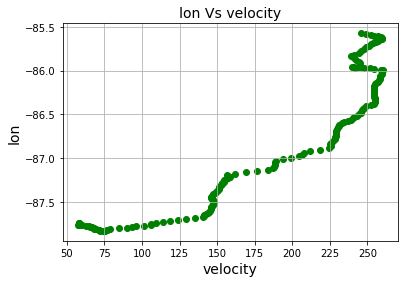

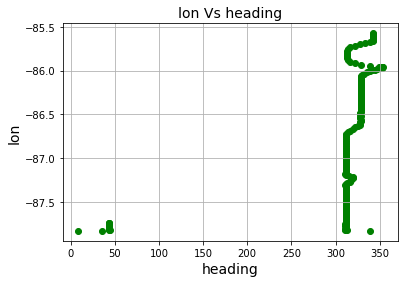

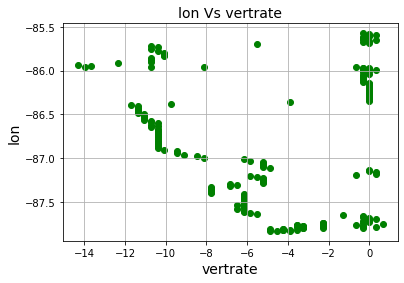

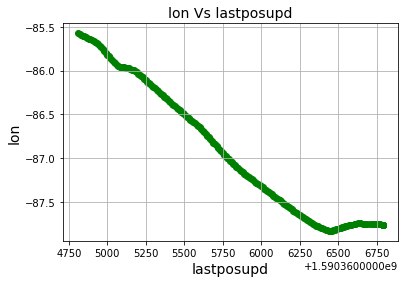

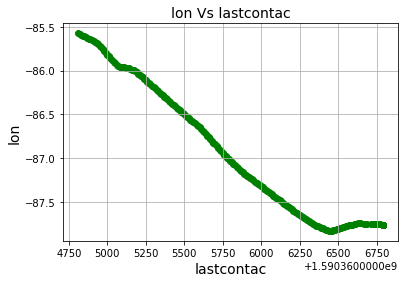

In [69]:
plt.scatter(df['velocity'], df['lon'], color='green')
plt.title('lon Vs velocity', fontsize=14)
plt.xlabel('velocity', fontsize=14)
plt.ylabel('lon', fontsize=14)
plt.grid(True)
plt.show()

#linear-ish

plt.scatter(df['heading'], df['lon'], color='green')
plt.title('lon Vs heading', fontsize=14)
plt.xlabel('heading', fontsize=14)
plt.ylabel('lon', fontsize=14)
plt.grid(True)
plt.show()
#not linear

plt.scatter(df['vertrate'], df['lon'], color='green')
plt.title('lon Vs vertrate', fontsize=14)
plt.xlabel('vertrate', fontsize=14)
plt.ylabel('lon', fontsize=14)
plt.grid(True)
plt.show()
#maybe slightly linear?

plt.scatter(df['lastposupd'], df['lon'], color='green')
plt.title('lon Vs lastposupd', fontsize=14)
plt.xlabel('lastposupd', fontsize=14)
plt.ylabel('lon', fontsize=14)
plt.grid(True)
plt.show()
#very linear

plt.scatter(df['lastcontac'], df['lon'], color='green')
plt.title('lon Vs lastcontac', fontsize=14)
plt.xlabel('lastcontac', fontsize=14)
plt.ylabel('lon', fontsize=14)
plt.grid(True)
plt.show()
#very linear-redundant variable?

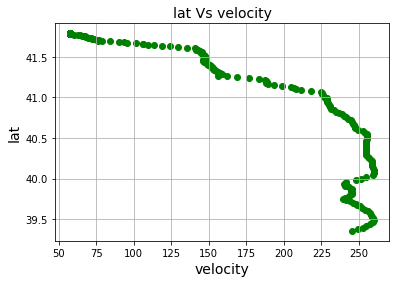

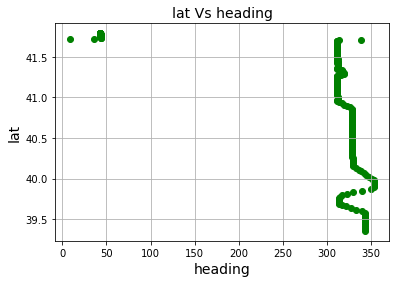

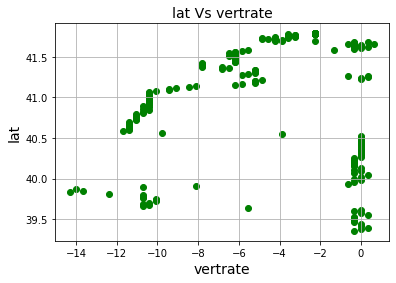

In [65]:
plt.scatter(df['velocity'], df['lat'], color='green')
plt.title('lat Vs velocity', fontsize=14)
plt.xlabel('velocity', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.grid(True)
plt.show()
#linear-ish

plt.scatter(df['heading'], df['lat'], color='green')
plt.title('lat Vs heading', fontsize=14)
plt.xlabel('heading', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.grid(True)
plt.show()
# Not linear
plt.scatter(df['vertrate'], df['lat'], color='green')
plt.title('lat Vs vertrate', fontsize=14)
plt.xlabel('vertrate', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.grid(True)
plt.show()
#maybe slightly linear?

In [82]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

# with statsmodels--lat
X = sm.add_constant(df[indep_vars]) # adding a constant
 
model_lat = sm.OLS(df[['lat']], X).fit()
predictions = model_lat.predict(X) 
 
print_model_lat = model_lat.summary()
print(print_model_lat)

                            OLS Regression Results                            
Dep. Variable:                    lat   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     292.3
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.94e-87
Time:                        11:11:38   Log-Likelihood:                -50.775
No. Observations:                 228   AIC:                             111.5
Df Residuals:                     223   BIC:                             128.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.184e-09   1.06e-09     -1.116      0.2

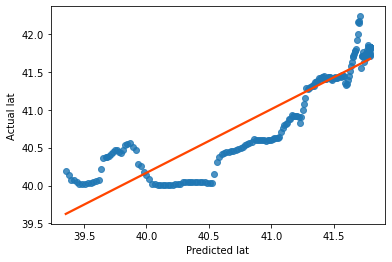

In [83]:
# lon values from statmodel package
#flatten vs the original arrays shape
ax = seaborn.regplot(
    df[['lat']].values.flatten(), 
    model_lat.fittedvalues, 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Predicted lat')
ax.set_ylabel('Actual lat');

In [80]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

# with statsmodels--lon
X = sm.add_constant(df[indep_vars]) # adding a constant
 
model_lon = sm.OLS(df[['lon']], X).fit()
predictions = model_lon.predict(X) 
 
print_model_lon = model_lon.summary()
print(print_model_lon)

                            OLS Regression Results                            
Dep. Variable:                    lon   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     599.1
Date:                Mon, 20 Dec 2021   Prob (F-statistic):          5.23e-118
Time:                        11:10:26   Log-Likelihood:                 19.732
No. Observations:                 228   AIC:                            -29.46
Df Residuals:                     223   BIC:                            -12.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.24e-10   7.79e-10      0.801      0.4

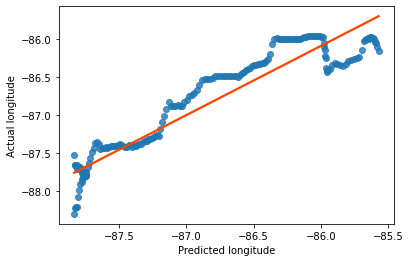

In [81]:
# lon values from statmodel package
#flatten vs the original arrays shape
ax = seaborn.regplot(
    df[['lon']].values.flatten(), 
    model_lon.fittedvalues, 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Predicted longitude')
ax.set_ylabel('Actual longitude');

41.790802001953125 39.353851318359375
44.657376614728435 41.76258799332478


Text(0.5, 1.0, 'Actual Flight a198e5')

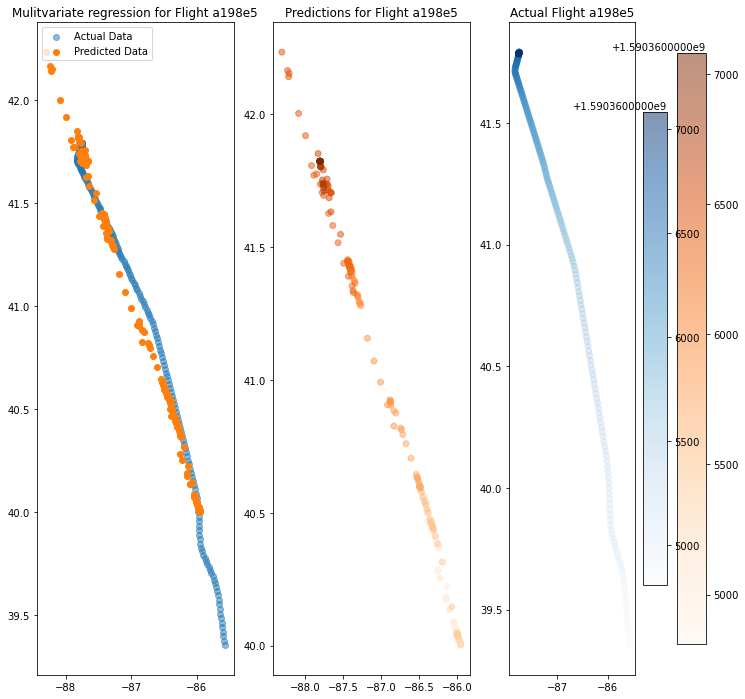

In [94]:
a_lat = df[['lat']].values.flatten()
a_lon = df[['lon']].values.flatten()
p_lat = model_lat.fittedvalues.to_numpy()
p_lon = model_lon.fittedvalues.to_numpy()

print(np.max(a_lat), np.min(a_lat))
print(np.max(mlat.predy.flatten()), np.min(mlat.predy.flatten()))

f, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].scatter(a_lon,a_lat, label='Actual Data', alpha= .5)#actual data
ax[0].legend(loc='upper left')
ax[0].scatter(p_lon,p_lat, label='Predicted Data')
ax[0].legend(loc='upper left')
# ax[0].axvline(x=p_lat[199], c='r', linestyle='--')
# ax[0].axhline(y=p_lon[199], c='r', linestyle='--')
ax[0].set_title('Mulitvariate regression for Flight a198e5')

pl1 = ax[1].scatter(model_lon.fittedvalues.to_numpy(),model_lat.fittedvalues.to_numpy(), label='predicted flight path', alpha= .5,c=df.index, cmap= 'Oranges')
plt.colorbar(pl1)
#ax[1].legend(loc='upper left')
ax[1].set_title('Predictions for Flight a198e5')

pl2 = ax[2].scatter(a_lon,a_lat, label='Actual flight path', alpha= .5, c=df.index, cmap= 'Blues')
plt.colorbar(pl2)
#ax[2].legend(loc='upper left')
ax[2].set_title('Actual Flight a198e5')
#data_predict

## Conclusions: 

multivaraite regression caclulated through statmodel has a much better result than the one calculated first (using pysal). based on the newly calulated LMSE, i can tell li have reduced error significantly for the lon and lat (compared to the fist multivariate model) but is not much better (if in fact a little worse) when compared to the LSTM output from Draft1 (for flight a198e5 all data: lat error: 0.18310829669040177 lon error: 0.12896144292247885, Test data: lat error: 0.02564239501953125 lon error: 0.0373382568359375)

In [95]:
mse_lat = sklearn.metrics.mean_squared_error(a_lat, p_lat)
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, p_lon)
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

#RMSE is measured in degrees 
 

lat error: 0.3023281197771596 lon error: 0.22190974606707023
